In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [2]:
# Load the diabetes dataset
from sklearn.datasets import load_diabetes

diabetes_datasets = load_diabetes()
print(diabetes_datasets['DESCR'])


.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
http://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Brad

In [3]:
# Save the input and target variables
print(diabetes_datasets.keys())
data = diabetes_datasets['data']
targets = diabetes_datasets['target']

dict_keys(['data', 'target', 'DESCR', 'feature_names', 'data_filename', 'target_filename'])


In [4]:
# Normalise the target data (this will make clearer training curves)
targets = (targets - targets.mean())/targets.std()
targets

array([-1.47194752e-02, -1.00165882e+00, -1.44579915e-01,  6.99512942e-01,
       -2.22496178e-01, -7.15965848e-01, -1.83538046e-01, -1.15749134e+00,
       -5.47147277e-01,  2.05006151e+00, -6.64021672e-01, -1.07957508e+00,
        3.48889755e-01,  4.26806019e-01, -4.43258925e-01,  2.45001404e-01,
        1.80071184e-01, -1.05621783e-01, -7.15965848e-01,  2.06043272e-01,
       -1.09256112e+00, -1.33929596e+00, -1.09256112e+00,  1.20596866e+00,
        4.13819975e-01,  6.47568766e-01, -1.96524090e-01, -8.71798376e-01,
       -2.74440354e-01,  1.69943833e+00, -3.00412442e-01, -1.20943552e+00,
        2.45262887e+00, -8.45826288e-01, -1.13151925e+00, -6.51035629e-01,
        1.46568953e+00,  1.60853602e+00,  1.29687096e+00, -8.06868156e-01,
       -6.77007716e-01, -1.26137969e+00, -1.18346343e+00, -7.80896068e-01,
        1.38777327e+00, -1.28735178e+00,  4.91736239e-01, -1.31593871e-01,
       -1.00165882e+00, -1.31593871e-01,  3.72247006e-02,  9.46247777e-01,
       -1.20943552e+00, -

In [5]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split

train_data, test_data, train_targets, test_targets = train_test_split(data,targets,test_size=0.1)

print(train_data.shape)
print(test_data.shape)


(397, 10)
(45, 10)


#### Train a feedforward neural network model

In [6]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_model():
    model = Sequential([Dense(128,activation='relu',input_shape=(train_data.shape[1],)),
                      Dense(128, activation='relu'),
                      Dense(128, activation='relu'),
                      Dense(128, activation='relu'),
                      Dense(128, activation='relu'),
                      Dense(128, activation='relu'),
                      Dense(1)
                       ])
    return model

model = get_model()

In [7]:
# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1

In [8]:
# Compile the model
model.compile(optimizer='adam',loss='mae',metrics=['mae'])


In [9]:
# Train the model, with some of the data reserved for validation
history = model.fit(train_data,train_targets,epochs=100,validation_split=0.15,batch_size=64,verbose=False)


In [10]:
# Evaluate the model on the test set
model.evaluate(test_data,test_targets,verbose=2)


45/1 - 0s - loss: 0.5258 - mae: 0.5385


[0.538501152727339, 0.53850114]

#### Plot the learning curves

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

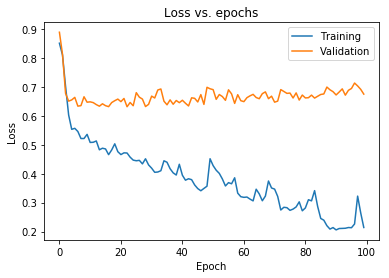

In [12]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [13]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [14]:
def get_regularised_model(wd, rate):
    model = Sequential([
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu", input_shape=(train_data.shape[1],)),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(1)
    ])
    return model

In [15]:
# Re-build the model with weight decay and dropout layers
model = get_regularised_model(1e-5,0.3)

In [16]:
# Compile the model
model.compile(optimizer='adam',loss='mae',metrics=['mae'])


In [17]:
# Train the model, with some of the data reserved for validation
history = model.fit(train_data,train_targets,epochs=100,validation_split=0.15,batch_size=64,verbose=1)



Train on 337 samples, validate on 60 samples
Epoch 1/100
337/337 [==============================] - 2s 6ms/sample - loss: 0.8590 - mae: 0.8524 - val_loss: 0.9064 - val_mae: 0.8998
Epoch 2/100
337/337 [==============================] - 0s 576us/sample - loss: 0.8508 - mae: 0.8443 - val_loss: 0.8839 - val_mae: 0.8773
Epoch 3/100
337/337 [==============================] - 0s 586us/sample - loss: 0.8368 - mae: 0.8303 - val_loss: 0.8478 - val_mae: 0.8413
Epoch 4/100
337/337 [==============================] - 0s 583us/sample - loss: 0.8081 - mae: 0.8015 - val_loss: 0.7760 - val_mae: 0.7695
Epoch 5/100
337/337 [==============================] - 0s 576us/sample - loss: 0.7509 - mae: 0.7443 - val_loss: 0.7214 - val_mae: 0.7149
Epoch 6/100
337/337 [==============================] - 0s 586us/sample - loss: 0.7512 - mae: 0.7447 - val_loss: 0.7127 - val_mae: 0.7062
Epoch 7/100
337/337 [==============================] - 0s 344us/sample - loss: 0.7182 - mae: 0.7117 - val_loss: 0.6977 - val_mae: 0.691

337/337 [==============================] - 0s 599us/sample - loss: 0.5174 - mae: 0.5111 - val_loss: 0.6354 - val_mae: 0.6291
Epoch 61/100
337/337 [==============================] - 0s 574us/sample - loss: 0.5113 - mae: 0.5049 - val_loss: 0.6634 - val_mae: 0.6571
Epoch 62/100
337/337 [==============================] - 0s 320us/sample - loss: 0.5262 - mae: 0.5198 - val_loss: 0.6809 - val_mae: 0.6745
Epoch 63/100
337/337 [==============================] - 0s 580us/sample - loss: 0.5166 - mae: 0.5103 - val_loss: 0.6620 - val_mae: 0.6557
Epoch 64/100
337/337 [==============================] - 0s 592us/sample - loss: 0.5206 - mae: 0.5143 - val_loss: 0.6231 - val_mae: 0.6167
Epoch 65/100
337/337 [==============================] - 0s 583us/sample - loss: 0.4870 - mae: 0.4807 - val_loss: 0.6495 - val_mae: 0.6431
Epoch 66/100
337/337 [==============================] - 0s 568us/sample - loss: 0.4928 - mae: 0.4865 - val_loss: 0.6589 - val_mae: 0.6526
Epoch 67/100
337/337 [=========================

In [18]:
# Evaluate the model on the test set
model.evaluate(test_data,test_targets,verbose=2)


45/1 - 0s - loss: 0.5883 - mae: 0.5875


[0.5937769638167487, 0.5874644]

#### Plot the learning curves

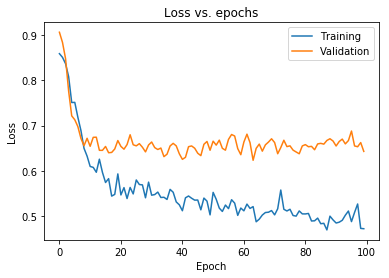

In [19]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [20]:
# Write a custom callback

from tensorflow.keras.callbacks import Callback

class TrainingCallBack(Callback):
    
    def on_train_begin(self, logs=None):
        print("Starting training....")
        
    def on_epoch_begin(self, epoch, logs=None):
        print(f"Starting epoch {epoch}")
        
    def on_train_batch_begin(self, batch, logs=None):
        print(f"Training: Starting batch {batch}")
    
    def on_train_batch_end(self, batch, logs=None):
        print(f"Training: Finished batch {batch}")
        
    def on_epoch_end(self, epoch, logs=None):
        print(f"Finished epoch {epoch}")
    
    def on_train_end(self, logs=None):
        print("Finished training!")
        
class TestingCallBack(Callback):
    
    def on_test_begin(self, logs=None):
        print("Starting testing....")
        
    def on_epoch_begin(self, epoch, logs=None):
        print(f"Starting epoch {epoch}")
        
    def on_test_batch_begin(self, batch, logs=None):
        print(f"Testing: Starting batch {batch}")
    
    def on_test_batch_end(self, batch, logs=None):
        print(f"Testing: Finished batch {batch}")
        
    def on_epoch_end(self, epoch, logs=None):
        print(f"Finished epoch {epoch}")
    
    def on_test_end(self, logs=None):
        print("Finished testing!")
        
class PredictionCallBack(Callback):
    
    def on_predict_begin(self, logs=None):
        print("Starting prediction....")
        
    def on_predict_batch_begin(self, batch, logs=None):
        print(f"Prediction: Starting batch {batch}")
    
    def on_predict_batch_end(self, batch, logs=None):
        print(f"Prediction: Finished batch {batch}")
    
    def on_prediction_end(self, logs=None):
        print("Finished prediction!")
        

In [21]:
# Re-build the model
model = get_regularised_model(1e-5, 0.3)


In [22]:
# Compile the model
model.compile(optimizer='adam', loss='mae')


#### Train the model with the callback

In [23]:
# Train the model, with some of the data reserved for validation14
model.fit(train_data, train_targets, epochs=3, batch_size=128, verbose=False, callbacks=[TrainingCallBack()])

Starting training....
Starting epoch 0
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Finished epoch 0
Starting epoch 1
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Finished epoch 1
Starting epoch 2
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Finished epoch 2
Finished training!


In [24]:
# Evaluate the model
model.evaluate(test_data, test_targets,verbose=False,callbacks=[TestingCallBack()])


Starting testing....
Testing: Starting batch 0
Testing: Finished batch 0
Testing: Starting batch 1
Testing: Finished batch 1
Finished testing!


0.7238965882195367

In [25]:
# Make predictions with the model
model.predict(test_data, verbose=False, callbacks=[PredictionCallBack()])


Starting prediction....
Prediction: Starting batch 0
Prediction: Finished batch 0
Prediction: Starting batch 1
Prediction: Finished batch 1


array([[-0.23350784],
       [-0.21900146],
       [-0.14575507],
       [-0.2917147 ],
       [-0.16490978],
       [-0.13196917],
       [-0.26929557],
       [-0.23991695],
       [-0.2807873 ],
       [-0.19840018],
       [-0.12241808],
       [-0.14847374],
       [-0.29427764],
       [-0.18584792],
       [-0.16844663],
       [-0.30516708],
       [-0.13338557],
       [-0.24863715],
       [-0.2382841 ],
       [-0.1542706 ],
       [-0.09810828],
       [-0.26712823],
       [-0.12813699],
       [-0.20727783],
       [-0.17353675],
       [-0.17014667],
       [-0.1370731 ],
       [-0.14991388],
       [-0.11694999],
       [-0.12531674],
       [-0.200736  ],
       [-0.34676468],
       [-0.27519348],
       [-0.1731253 ],
       [-0.1544345 ],
       [-0.13987198],
       [-0.11627595],
       [-0.24136207],
       [-0.25851357],
       [-0.10654125],
       [-0.27299532],
       [-0.21947196],
       [-0.28939933],
       [-0.14514628],
       [-0.2587646 ]], dtype=flo

***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [26]:
# Re-train the unregularised model
unregularised_model = get_model()
unregularised_model.compile(optimizer='adam', loss='mae')
unreg_history = unregularised_model.fit(train_data,train_targets,epochs=100,validation_split=0.15,batch_size=64,verbose=False,callbacks=[tf.keras.callbacks.EarlyStopping()])


In [27]:
# Evaluate the model on the test set

unregularised_model.evaluate(test_data, test_targets, verbose=2)


45/1 - 0s - loss: 0.5486


0.549430623319414

In [28]:
# Re-train the regularised model
regularised_model = get_regularised_model(1e-8,0.2)
regularised_model.compile(optimizer='adam', loss='mae')
reg_history = regularised_model.fit(train_data, train_targets, epochs=100,validation_split=0.15,batch_size=64,verbose=False,callbacks=[tf.keras.callbacks.EarlyStopping()])


In [29]:
# Evaluate the model on the test set
regularised_model.evaluate(test_data, test_targets, verbose=2)


45/1 - 0s - loss: 0.5322


0.559618263774448

#### Plot the learning curves

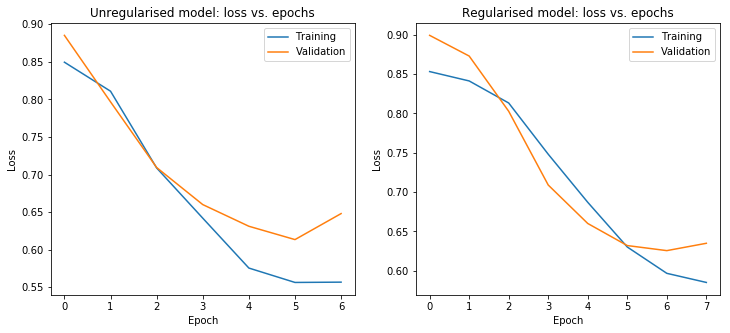

In [30]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()